In [358]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%pylab inline
import warnings
import os
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


### Функции предобработок (с предыдущих недель)

In [359]:
# выбор тех регионов, из которых в среднем осущесвтляется больше 5 поездок
def chose_refions_with_rides(df):
    df.index = pd.to_datetime(df.index)
    
    # выделяем час из даты
    df['pickup_data'] = df.index
    df['pickup_hour'] = df['pickup_data'].dt.hour

    # число дней в месяце
    days_in_month = df['pickup_data'][0].days_in_month
    df = df.drop('pickup_data',axis = 1)
    # групируем число поездок по часам
    rides_in_hour =[]
    for i in range(0,24):
        rides_in_hour.append(df[df['pickup_hour']  == i].sum())

    df_hours = pd.DataFrame(rides_in_hour)
    df_hours = df_hours.drop('pickup_hour',axis = 1)
    
    means = df_hours.apply(np.mean)
    return np.array(means[(means/days_in_month > 5)].index)

In [360]:
# сведение всех данных в одну таблицу
def read_region_from_data(dataDir, start_year, start_month, last_year, last_month, columns):
    columns = np.append(columns,'Unnamed: 0')
    month = start_month
    year = start_year

    df = pd.DataFrame()
    while os.path.exists(dataDir + '/trip_count_%d-%02d.csv'% (year, month) ):  
        
        month_data = pd.read_csv(dataDir + '/trip_count_%d-%02d.csv' % (year, month), usecols = columns)       
        month_data.set_index(['Unnamed: 0'], inplace=True)      
        df = pd.concat((df,month_data), axis = 0)
        # Return on last month and year
        if (month == last_month and year == last_year):
            df.index.name = 'time'
            
            df.index = pd.to_datetime(df.index)
            return df

        # Increment month
        if (month == 12):
            month = 1
            year += 1
        else:
            month += 1
        

### Получение итоговой таблицы поездок (с предыдущей недели)
(с вычетом непопулярных регионов, определённых по маю 2016г)


In [361]:
filename = 'trip_count_2016-05.csv'
dataFolder = 'trips'
    
df = pd.read_csv(dataFolder+ '/' + filename, index_col = 0)
df.index = pd.to_datetime(df.index)
region_columns = chose_refions_with_rides(df)

In [362]:
data = read_region_from_data('trips', 2016, 1, 2016, 6, region_columns)

In [363]:
# преобразуем данные
regions_data = data.stack().reset_index()
regions_data.columns = ['time', 'region','count']
regions_data.region = pd.to_numeric(regions_data.region)
regions_data.count = pd.to_numeric(regions_data.region)

### Сформируем 6 выборок

In [364]:
regions_data['y1']=regions_data.groupby(['region'])['count'].shift(-1)
regions_data['y2']=regions_data.groupby(['region'])['count'].shift(-2)
regions_data['y3']=regions_data.groupby(['region'])['count'].shift(-3)
regions_data['y4']=regions_data.groupby(['region'])['count'].shift(-4)
regions_data['y5']=regions_data.groupby(['region'])['count'].shift(-5)
regions_data['y6']=regions_data.groupby(['region'])['count'].shift(-6)

In [365]:
# добавим колонку row для ввода признаков регрессионных моделей 
regions_data=regions_data.sort_values(['region', 'time'])
regions_data['row']=regions_data.groupby(['region'])['time'].rank(ascending=1)

In [366]:
regions_data.head(10)

,time,region,count,y1,y2,y3,y4,y5,y6,row
0,2016-01-01 00:00:00,1075,80,91.0,90.0,32.0,24.0,11.0,7.0,1.0
102,2016-01-01 01:00:00,1075,91,90.0,32.0,24.0,11.0,7.0,9.0,2.0
204,2016-01-01 02:00:00,1075,90,32.0,24.0,11.0,7.0,9.0,18.0,3.0
306,2016-01-01 03:00:00,1075,32,24.0,11.0,7.0,9.0,18.0,22.0,4.0
408,2016-01-01 04:00:00,1075,24,11.0,7.0,9.0,18.0,22.0,27.0,5.0
510,2016-01-01 05:00:00,1075,11,7.0,9.0,18.0,22.0,27.0,54.0,6.0
612,2016-01-01 06:00:00,1075,7,9.0,18.0,22.0,27.0,54.0,91.0,7.0
714,2016-01-01 07:00:00,1075,9,18.0,22.0,27.0,54.0,91.0,147.0,8.0
816,2016-01-01 08:00:00,1075,18,22.0,27.0,54.0,91.0,147.0,124.0,9.0
918,2016-01-01 09:00:00,1075,22,27.0,54.0,91.0,147.0,124.0,135.0,10.0


Лиричекое отступление:
Я решил пока что не добавлять результаты предыдущей недели: долго считать. Вместо этого добавим скользящее среднее с окном в 6 часов
Но думаю к след. неделе посчитаю и с SARIMAX результатами.

In [367]:
# регрессионные признаки
K=7
for i in range(1,K+1):
    regions_data.loc[:,'sink'+str(i)]=np.sin(regions_data.row*2*np.pi*i/168.0)
    regions_data.loc[:,'cosk'+str(i)]=np.cos(regions_data.row*2*np.pi*i/168.0)

In [368]:
# признаки по дням недели
regions_data['week']= pd.DatetimeIndex(regions_data.time).dayofweek
regions_data['day']= pd.DatetimeIndex(regions_data.time).day
regions_data['hour']= pd.DatetimeIndex(regions_data.time).hour

In [369]:
#Скользящее среднее : число поездок последних 6 часов
tmp=regions_data.groupby(['region'])['count'].rolling(6).sum()
tmp=tmp.reset_index()

In [370]:
tmp.index=tmp.level_1
del tmp['region'] 
del tmp['level_1']
regions_data['last_6_hours_sum'] = tmp['count']

In [371]:
regions_data['last_6_hours_mean']=regions_data['last_6_hours_sum']/6

In [372]:
#1to6_h_ago признак равен значению час назад для y1, значению 2 часа назад для y2 и тд, 
#ну и еще признаки 2 часа назад для y1 и тп.
regions_data['1to6_h_ago']=regions_data['count']
regions_data['2to7_h_ago']=regions_data.groupby(['region'])['count'].shift(1)
regions_data['3to8_h_ago']=regions_data.groupby(['region'])['count'].shift(2)

In [373]:
#параметры числа поездок из р-на в прошлый день
regions_data['y1_sh24']=regions_data.groupby(['region'])['y1'].shift(24)
regions_data['y2_sh24']=regions_data.groupby(['region'])['y2'].shift(24)
regions_data['y3_sh24']=regions_data.groupby(['region'])['y3'].shift(24)
regions_data['y4_sh24']=regions_data.groupby(['region'])['y4'].shift(24)
regions_data['y5_sh24']=regions_data.groupby(['region'])['y5'].shift(24)
regions_data['y6_sh24']=regions_data.groupby(['region'])['y6'].shift(24)

In [374]:
#параметры числа поездок из р-на в прошлую неделю
regions_data['y1_sh168']=regions_data.groupby(['region'])['y1'].shift(168)
regions_data['y2_sh168']=regions_data.groupby(['region'])['y2'].shift(168)
regions_data['y3_sh168']=regions_data.groupby(['region'])['y3'].shift(168)
regions_data['y4_sh168']=regions_data.groupby(['region'])['y4'].shift(168)
regions_data['y5_sh168']=regions_data.groupby(['region'])['y5'].shift(168)
regions_data['y6_sh168']=regions_data.groupby(['region'])['y6'].shift(168)

In [375]:
regions_data.index = regions_data.time

In [378]:
train_time_start = '2016-01-02'
train_time_end = '2016-04-30 23:00:00'
test_time_start = '2016-05-01'
test_time_end = '2016-05-31 17:00:00'

In [379]:
# функция получения идентификатора для проведения сабмита
def get_id(x, a):
    return str(x[0])+'_'+str(x[1])[:10]+'_'+str(int(str(x[1])[11:13]))+'_'+str(a)

Чтобы не возиться с категориальными переменными, просто положим всё в xgboost

In [407]:
def make_prediction(train_time_start,train_time_end,test_time_start,test_time_end, error_for_month, submit = False):

    abs_err_sum=0
    df_submit = pd.DataFrame()
    for i in ['y1','y2','y3','y4','y5','y6']:
        columns_to_use = [ u'region',u'week', u'day',u'hour',
                           u'sink1', u'cosk1', u'sink2', u'cosk2', u'sink3', u'cosk3',
                           u'sink4', u'cosk4', u'sink5', u'cosk5', u'sink6', u'cosk6',
                           u'sink7', u'cosk7', 
                           u'1to6_h_ago', u'2to7_h_ago', u'3to8_h_ago', 
                           u'last_6_hours_mean', u'last_6_hours_sum',
                           i+'_sh24', i+'_sh168']

        X_train=regions_data[columns_to_use][train_time_start:train_time_end]
        Y_train=regions_data[[i]][train_time_start:train_time_end]

        X_test=regions_data[columns_to_use][test_time_start:test_time_end]

        T_train_xgb = xgb.DMatrix(X_train, Y_train)
        
        # оставим параметры по умолчанию: они творят чудеса
        params = {}
        gbm = xgb.train(dtrain = T_train_xgb, params = params)
        Y_pred = gbm.predict(xgb.DMatrix(X_test))

        predictions = pd.DataFrame(regions_data[[i,'region']][test_time_start:test_time_end])
        predictions['pred'] = Y_pred
        predictions.loc[predictions.pred < 0,'pred'] = 0.0
        
        if(submit):          
            predictions['hour'] = X_test.index
            predictions['id'] = predictions[['region', 'hour']].apply(get_id,args=[i[1]], axis=1)
            df_submit = pd.concat([df_submit, predictions[['id', 'pred']]], axis=0)

        abs_err_sum=abs_err_sum + np.sum(np.abs(predictions.pred - predictions[i]))
        print ('Current error:', abs_err_sum)

    print ('Q error for period: ',abs_err_sum / error_for_month)
           
    return predictions, df_submit

In [388]:
predictions, _ = make_prediction(train_time_start,train_time_end,test_time_start,test_time_end, 102*739*6)

Current error: 1325324.286728561
Current error: 2842917.1408284307
Current error: 4419352.290310204
Current error: 6007068.868725121
Current error: 7620598.09896785
Current error: 9237050.46862775
Q error for period:  20.423842652205664


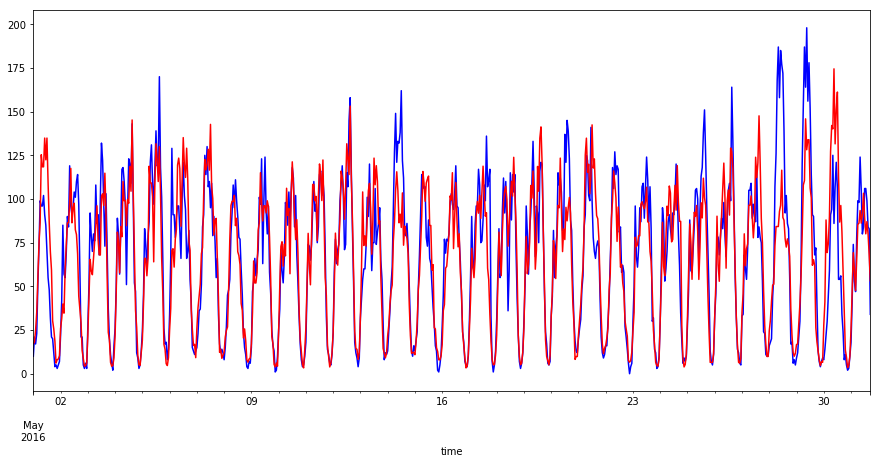

In [392]:
# проверка предсказаний
%matplotlib inline 
plt.figure(figsize=(15,7))
predictions[predictions.region==1075].y6[test_time_start:test_time_end].plot(color='b')
predictions[predictions.region==1075].pred[test_time_start:test_time_end].plot(color='r')

Местами хорошо, да и ошибка поменьше, чем на пролой неделе

In [404]:
# июнь
train_time_start = '2016-01-02'
train_time_end = '2016-05-31 22:00:00'
test_time_start = '2016-05-31 23:00:00'
test_time_end = '2016-06-30 17:00:00'

In [408]:
_, submit_june = make_prediction(train_time_start,train_time_end,test_time_start,test_time_end, 102*715*6, True)

Index(['id', 'pred'], dtype='object')
Current error: 1247243.6344673634
Index(['id', 'pred'], dtype='object')
Current error: 2655734.4557999372
Index(['id', 'pred'], dtype='object')
Current error: 4107387.6349728107
Index(['id', 'pred'], dtype='object')
Current error: 5571249.988109589
Index(['id', 'pred'], dtype='object')
Current error: 7052363.514480829
Index(['id', 'pred'], dtype='object')
Current error: 8539885.958462
Q error for period:  19.516170662420585


In [409]:
submit_june.head()

,id,pred
time,,
2016-05-31 23:00:00,1075_2016-05-31_23_1,26.092333
2016-06-01 00:00:00,1075_2016-06-01_0_1,17.188984
2016-06-01 01:00:00,1075_2016-06-01_1_1,9.973756
2016-06-01 02:00:00,1075_2016-06-01_2_1,6.698097
2016-06-01 03:00:00,1075_2016-06-01_3_1,3.950209


In [410]:
submit_june.columns = ['id','y']

In [412]:
submit_june.to_csv('test_w5.csv', index=False)

https://inclass.kaggle.com/c/yellowtaxi/leaderboard?submissionId=4984481  (19.51614)